# METADATA
- fixation time graph
- task completion time
- subject variation in fixation

In [1]:
import os, csv, pickle, gzip, torch, copy
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.transform import Rotation as R

from tqdm import tqdm
from matplotlib import rc #change xtick & ytick size
%matplotlib notebook
%matplotlib inline
matplotlib.rcParams['font.family'] = "Arial"
from scipy.signal import butter, lfilter, freqz


#========= read =========================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)
# df_files(dffile): (param df data for all subject, file pairs)
# 	sub_idx	file_idx	is_exclude	start_idx	end_idx	length	h	v	d	x	y	z

def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output

#========= read =========================================================================
"""
sfile: sorted params for each subject
ffile: trimmed feature files for all subs
dffile: time metadatafile for all subs
PARAMS: pamareter file for all subs


"""
spath = "data/data_feature/sorted-params.csv"
sfile = open(spath, 'r', encoding='utf-8')
sfile = list(csv.reader(sfile))

# ver2 file makes vector feature velocity to hold a and b instead of simple subtraction that is useless
file_name = "0919-f18r16ver2"
fpath = "data/data_feature/" + file_name + ".gz"
ffile = read_gzip(fpath)

dfpath = "data/data_feature/0216-df.csv"
dffile = pd.read_csv(dfpath, na_values=" NaN").dropna(how='all', axis=1)
dffile = dffile[['sub_idx','file_idx','length', 'orig_length','h','v','d']]
print(dffile.head)

params_df = dffile[['h','v','d']]
params_tensor = torch.tensor(params_df.values, dtype=torch.float32)
PARAMS = params_tensor.reshape(24, 144, 3)
# print(PARAMS[0])

open gzip
<bound method NDFrame.head of       sub_idx  file_idx  length  orig_length          h          v         d
0           0         0     347          533   0.000000   0.000000  2.500000
1           0         1     208          482 -30.000000   0.000000  2.500000
2           0         2     174          379   0.000000 -20.000000  1.700000
3           0         3     179          413   0.000000 -20.000000  1.700000
4           0         4     245          532  30.000000  20.000000  1.700000
...       ...       ...     ...          ...        ...        ...       ...
3451       23       139     121          288   9.601141  -3.255767  1.184000
3452       23       140     147          387  11.381922  12.234083  3.105820
3453       23       141     167          342 -12.825254 -19.560210  3.005871
3454       23       142     180          328  24.112133 -14.015582  3.207976
3455       23       143      -1          380 -26.686569  19.130858  1.690620

[3456 rows x 7 columns]>


## 1. Visualize Completion Time with (bar chart & distribution graph)
- bar chart is more intuitive
- KD graph can lead to misleading comprehension of data due to density values

C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_14796\2091595278.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'sub_idx'] = data.loc[:,'sub_idx']  +1
C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_14796\2091595278.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'length'] = data.loc[:,'length'] / 120


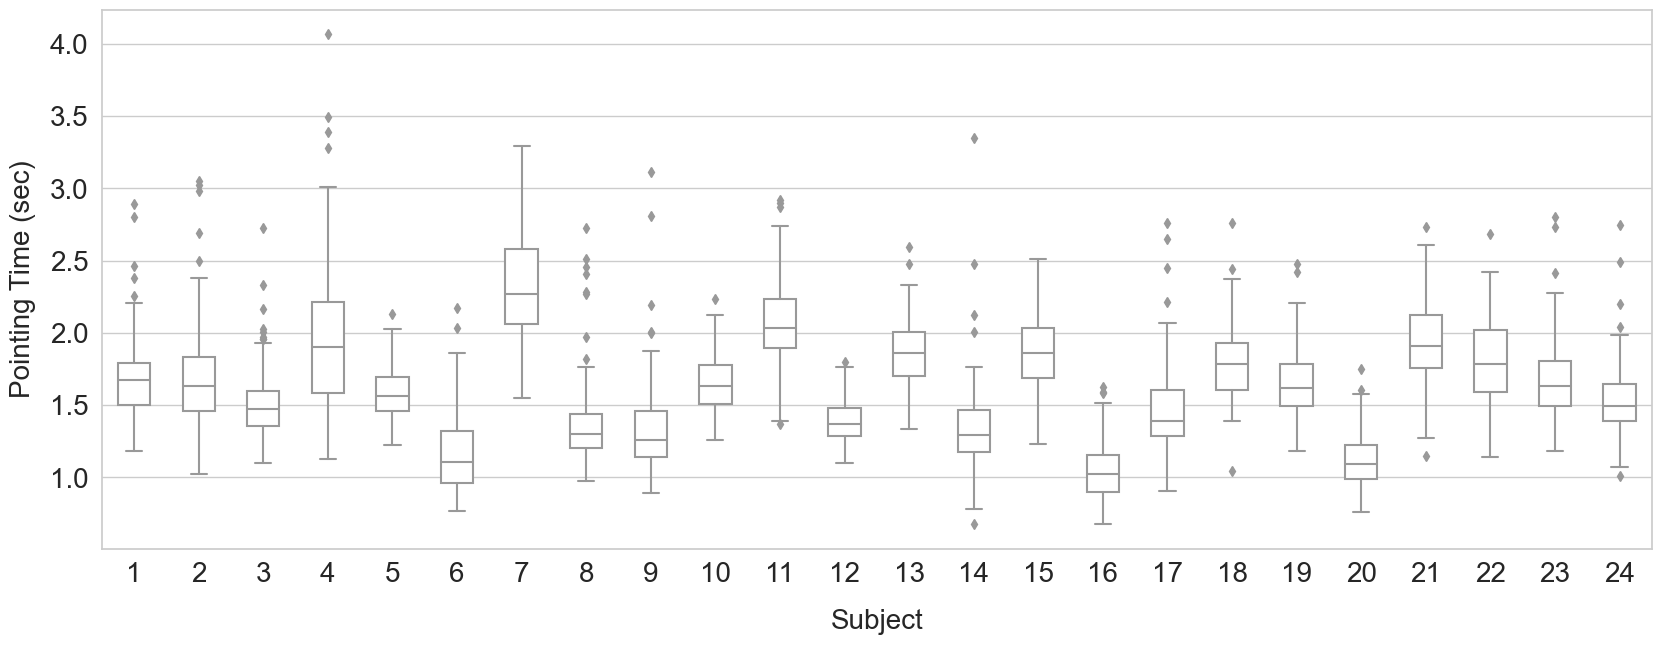

In [49]:
# data1 = file_method_grouping.loc[file_method_grouping['plot'] == 'gesture_distinction']

data = dffile[dffile.length != -1]
data.loc[:,'sub_idx'] = data.loc[:,'sub_idx']  +1
data.loc[:,'length'] = data.loc[:,'length'] / 120
fig1 = plt.figure(figsize = (20,7))
sns.set(style="ticks", palette='Set3')
sns.set_style("whitegrid")
plot = sns.boxplot(x='sub_idx', y='length', data=data, color='white', width=0.5)
plot.set_xlabel("Subject",fontsize=20, labelpad=15)
plot.set_ylabel("Pointing Time (sec)",fontsize=20, labelpad=10)
plot.tick_params(labelsize=20)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})   
# plt.title('completion_time', fontdict = {'fontsize' : 20})

## 2. Velocity Chart SUM(ABS(all v18 elements))
- will not do plotting. Just writing here

## 3. 

In [10]:
tips = sns.load_dataset("tips")
print(tips.head)

<bound method NDFrame.head of      total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]>
